In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from math import sqrt

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
hospital_table_3 = pd.read_csv(r"hospital_table_3.csv",parse_dates=['Date'], index_col='Date')
hospital_table_3.head()

,hospitalized,% hospitalized women,avg age hospitalized,respirated,% women on a respirator,avg age on a respirator,% unvaccinated on a respirator,mild sick,%mild sick women,% mild sick unvaccinated,avg mild sick,moderate sick,% women moderate sick,unvaccinated moderate sick,avg age moderate sick,critical sick,% critical sick women,% unvaccinated critical sick,avg age critical sick
Date,,,,,,,,,,,,,,,,,,,
2020-03-11,79,45.6,47.8,7.0,40.0,63.8,100.0,72.0,45.8,100.0,46.2,0.0,0.0,0.0,0.0,6.0,50.0,100.0,67.3
2020-03-12,102,49.0,49.9,2.0,40.0,63.8,100.0,95.0,49.5,100.0,48.9,0.0,0.0,0.0,0.0,1.0,50.0,100.0,67.3
2020-03-13,120,47.5,49.2,8.0,40.0,63.8,100.0,109.0,47.7,100.0,47.3,6.0,40.0,100.0,68.0,3.0,50.0,100.0,67.3
2020-03-14,158,49.4,47.4,12.0,0.0,70.3,100.0,148.0,50.7,100.0,45.7,2.0,40.0,100.0,68.0,10.0,20.0,100.0,76.8
2020-03-15,197,51.8,46.5,6.0,20.0,74.0,100.0,183.0,52.5,100.0,44.6,10.0,50.0,100.0,61.3,8.0,37.5,100.0,79.0


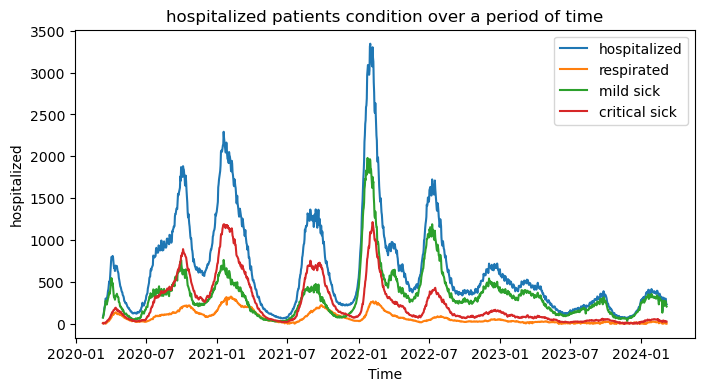

In [3]:
# 
sick = pd.DataFrame(hospital_table_3, columns=["hospitalized","respirated","mild sick","critical sick"])
# Visualizing the dataset
plt.figure(figsize=(8,4))
plt.plot(sick, label=['hospitalized','respirated','mild sick','critical sick'])
plt.title('hospitalized patients condition over a period of time')
plt.xlabel('Time')
plt.ylabel('hospitalized')
plt.legend()
plt.show()

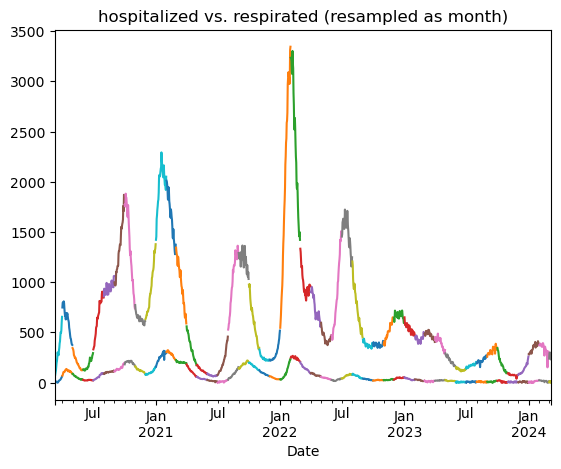

In [4]:
# Resample - read more here: https://www.datacamp.com/tutorial/pandas-resample-asfreq
sick.resample('M').respirated.plot(); 
sick.resample('M').hospitalized.plot();
# sick.resample('M').critical sick.plot(); need to fic title column to critical_sick for plot
plt.title('hospitalized vs. respirated (resampled as month)')
plt.show()

In [5]:
sick.isnull().sum()

hospitalized     0
respirated       0
mild sick        0
critical sick    0
dtype: int64

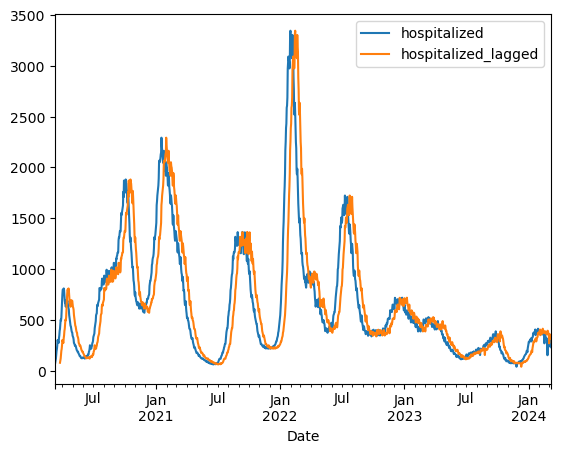

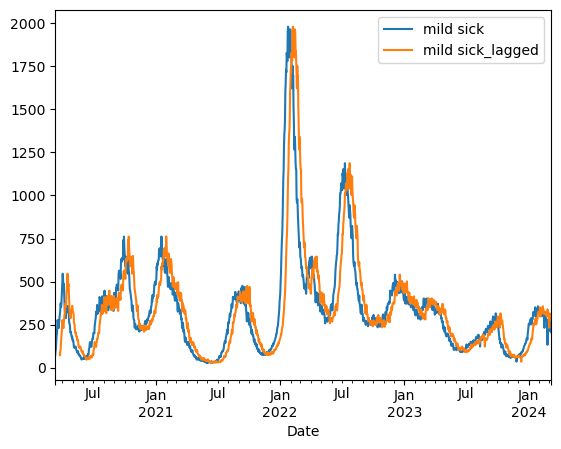

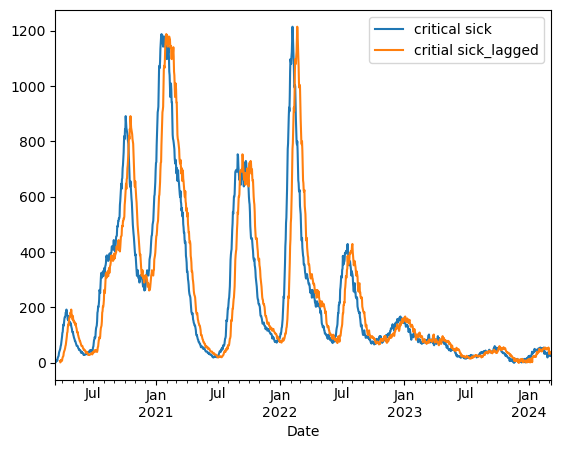

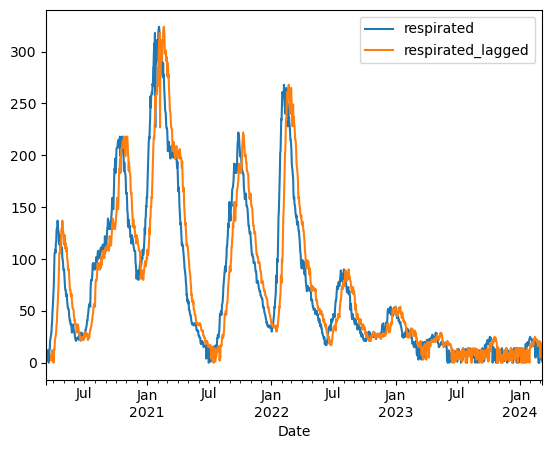

In [6]:
# using plot visualization to get an idea of how far can we predict using the current data?
sick["hospitalized"].plot(legend=True)
shifted = sick["hospitalized"].shift(14).plot(legend=True)
shifted.legend(['hospitalized','hospitalized_lagged'])
plt.show()

sick["mild sick"].plot(legend=True)
shifted = sick["mild sick"].shift(14).plot(legend=True)
shifted.legend(['mild sick','mild sick_lagged'])
plt.show()

sick["critical sick"].plot(legend=True)
shifted = sick["critical sick"].shift(14).plot(legend=True)
shifted.legend(['critical sick','critial sick_lagged'])
plt.show()

sick["respirated"].plot(legend=True)
shifted = sick["respirated"].shift(14).plot(legend=True)
shifted.legend(['respirated','respirated_lagged'])
plt.show()

In [7]:
# incresed visable excpected time deviation after the 14 days=2 week mark, possible that prediction should be for short terms

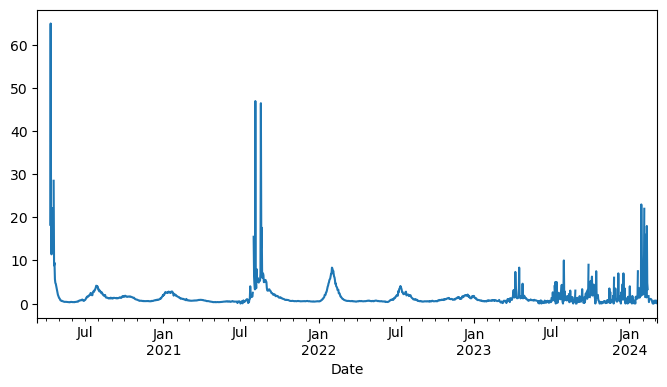

In [8]:
# Percent of change in successive rows
sick['Change'] = sick.respirated.div(sick.respirated.shift(30))
sick['Change'].plot(figsize=(8,4));

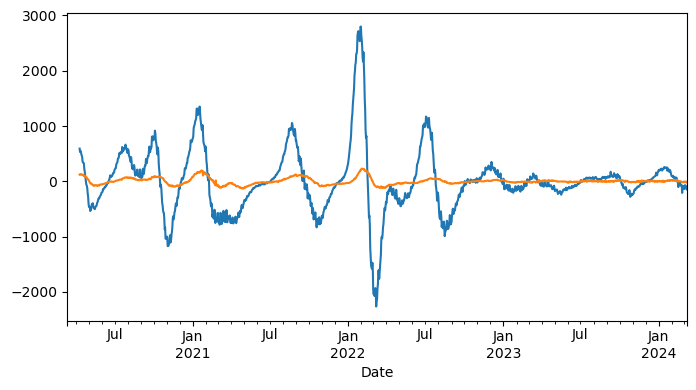

In [9]:
# Absolute change in successive rows
sick.hospitalized.diff(30).plot(figsize=(8,4));
sick.respirated.diff(30).plot(figsize=(8,4));

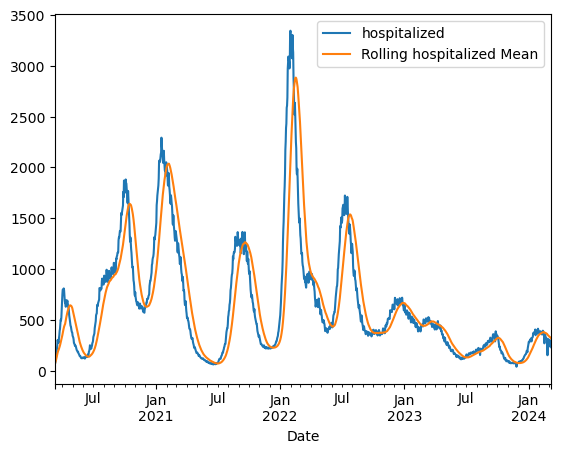

In [10]:
# Rolling window functions - smoothing the data
rolling_data = sick.hospitalized.rolling('30D').mean()
sick.hospitalized.plot()
rolling_data.plot()
plt.legend(['hospitalized','Rolling hospitalized Mean'])
# Plotting a rolling mean of 90 day window with original
plt.show()


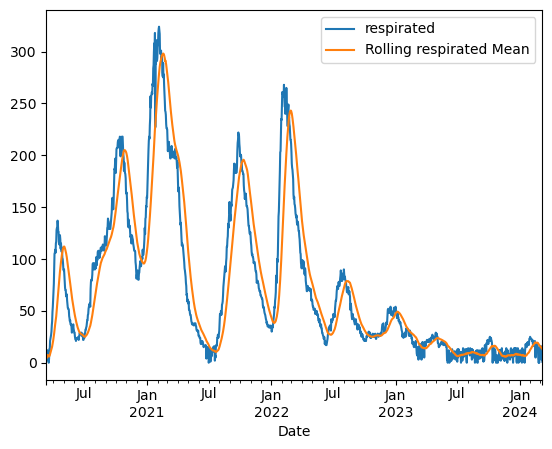

In [11]:
# Rolling window functions - smoothing the data
rolling_data = sick.respirated.rolling('30D').mean()
sick.respirated.plot()
rolling_data.plot()
plt.legend(['respirated','Rolling respirated Mean'])
# Plotting a rolling mean of 90 day window with original
plt.show()



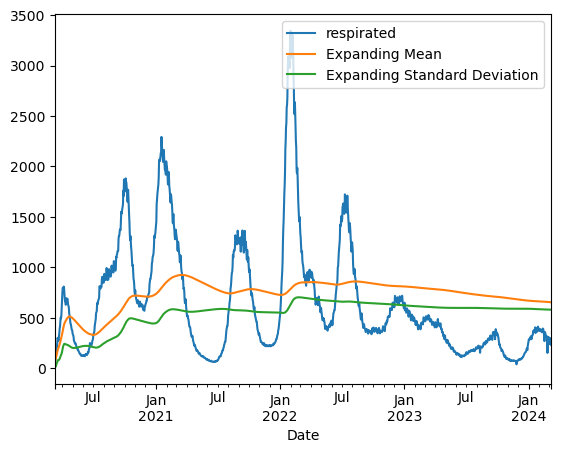

In [12]:
# Expanding window functions - the value of the statistic with all the data available up to that point in time
data_mean = sick.hospitalized.expanding().mean()
data_std = sick.hospitalized.expanding().std()
sick.hospitalized.plot()
data_mean.plot()
data_std.plot()
plt.legend(['respirated','Expanding Mean','Expanding Standard Deviation'])
plt.show()

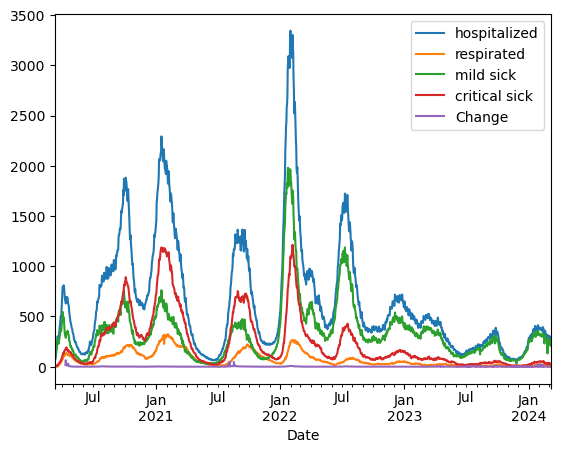

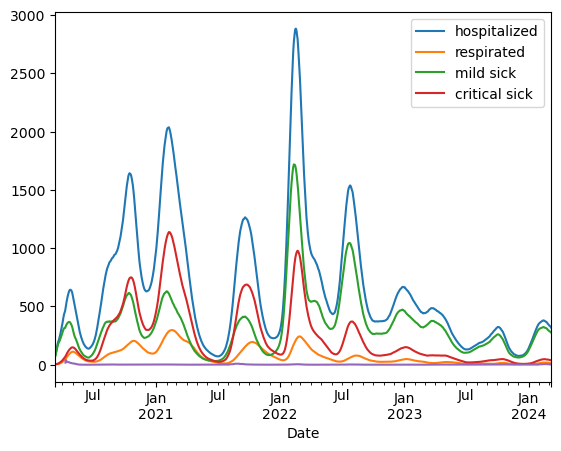

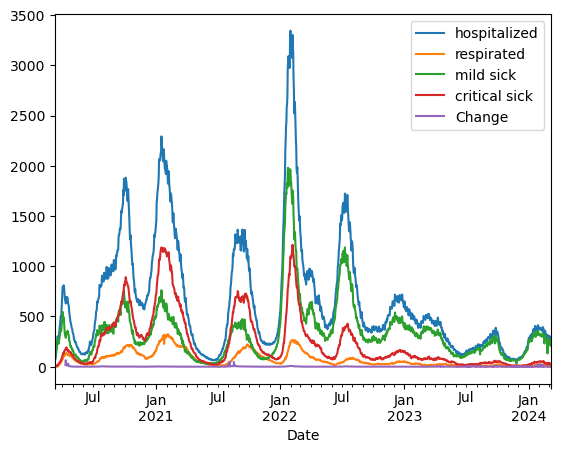

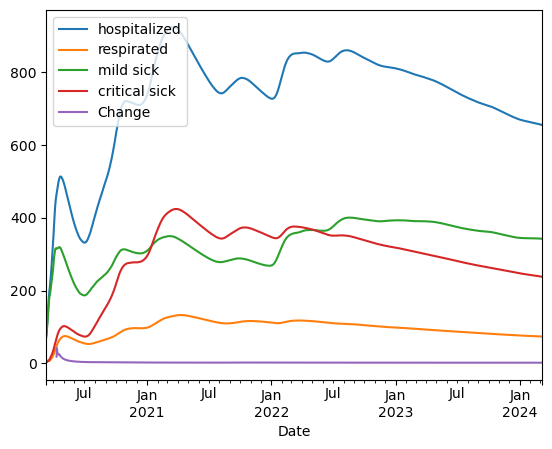

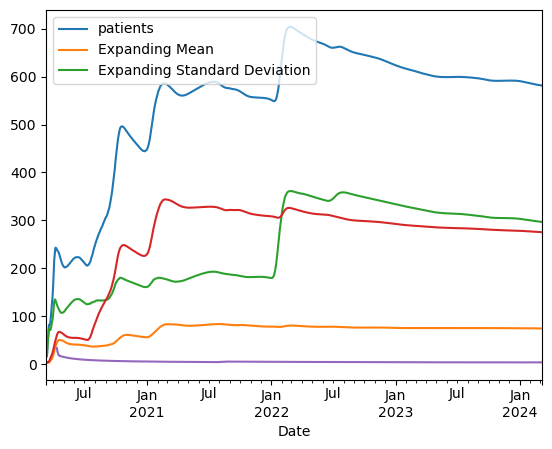

In [13]:
# Rolling window functions - smoothing the data
rolling_data = sick.rolling('30D').mean()
sick.plot()
rolling_data.plot()
plt.legend(['hospitalized','respirated','mild sick','critical sick'])
# Plotting a rolling mean of 30 day window with original
plt.show()

# Expanding window functions - the value of the statistic with all the data available up to that point in time
data_mean = sick.expanding().mean()
data_std = sick.expanding().std()
sick.plot()
data_mean.plot()
data_std.plot()
plt.legend(['patients','Expanding Mean','Expanding Standard Deviation'])
plt.show()

Seasonality refers to periodic fluctuations inther data that occur at regular intervals, such as daily, weekly, monthly, or yearly.

#### Identifying Seasonality
One way to spot seasonality in the data is through visual inspection. Plotting the time-series data can reveal obvious cycles.

TS Decomposition = Trend + Seasonality + Residuals
Trends, seasonality and noise - are the components of a time series.

Trend - Consistent upwards or downwards slope of a time series

Seasonality - Clear periodic pattern of a time series(like sine function)

Noise - Outliers or missing values

In [16]:
sick.isnull().sum() # change siginifcant number of null so to use backforward field to fix

hospitalized      0
respirated        0
mild sick         0
critical sick     0
Change           30
dtype: int64

In [17]:
# Dealing with missing data - backward/forward fill 
## use next valid observation to fill gap (taking from the future) bfill / propagate last valid observation forward to next valid (taking from the past)
nsick = sick.fillna(method='bfill')
nsick.tail()
# seems to give same results with both

,hospitalized,respirated,mild sick,critical sick,Change
Date,,,,,
2024-03-03,298,16.0,264.0,33.0,0.695652
2024-03-04,299,3.0,270.0,27.0,0.130435
2024-03-05,298,14.0,267.0,30.0,0.608696
2024-03-06,236,14.0,211.0,24.0,0.636364
2024-03-07,231,1.0,205.0,24.0,0.047619


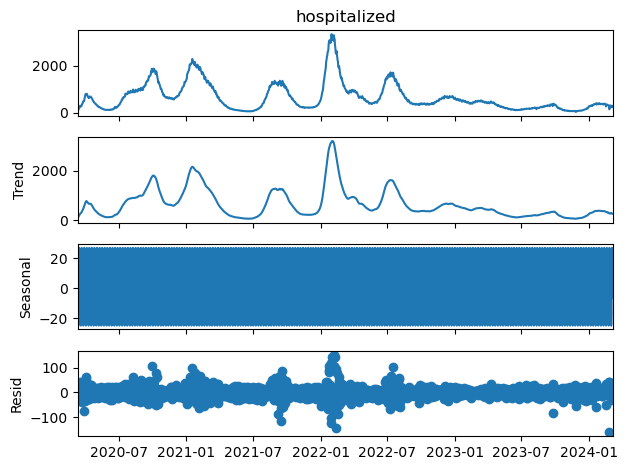

In [18]:
# Decomposing the time series
# Decomposition expects a series where data points follow one another in their natural temporal order.
decomposition_add1 = seasonal_decompose(nsick['hospitalized'], model='additive')
decomposition_add1.plot()

plt.show()

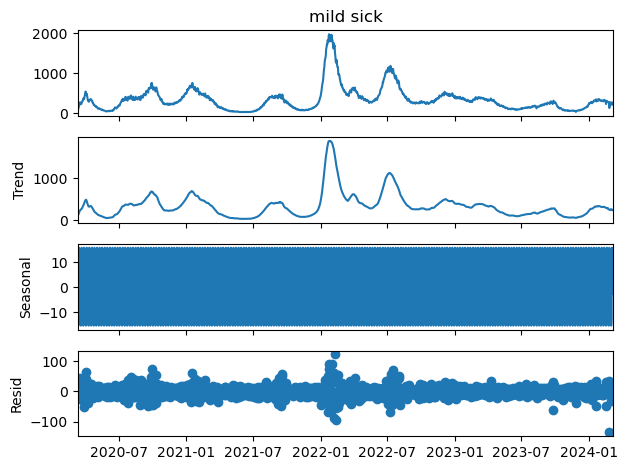

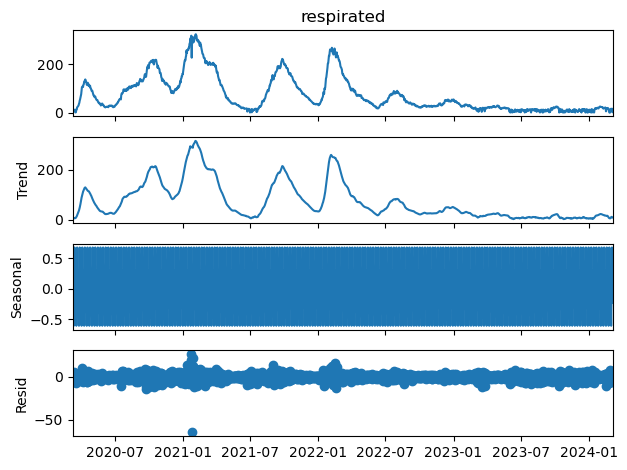

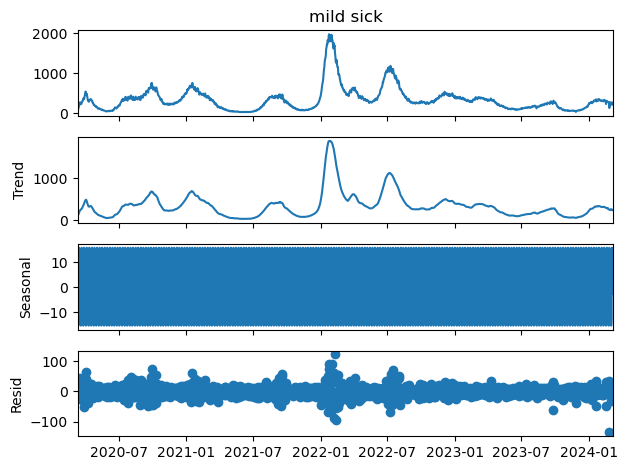

In [19]:
decomposition_add2 = seasonal_decompose(nsick['respirated'], model='additive')
decomposition_add3 = seasonal_decompose(nsick['mild sick'], model='additive')
decomposition_add2.plot()
decomposition_add3.plot()

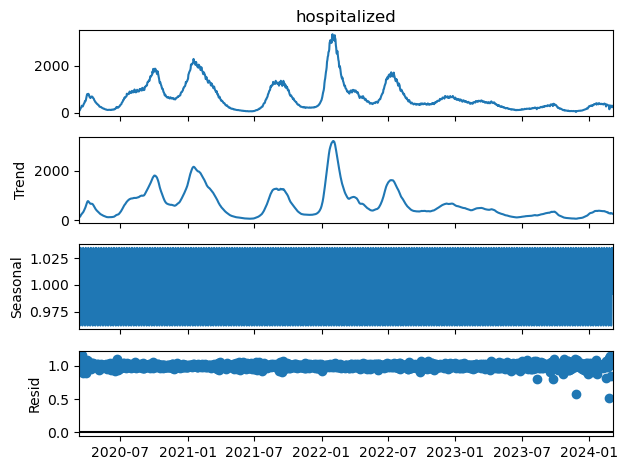

In [20]:
decomposition_mult = seasonal_decompose(nsick['hospitalized'], model='multiplicative')
decomposition_mult.plot()
plt.show()

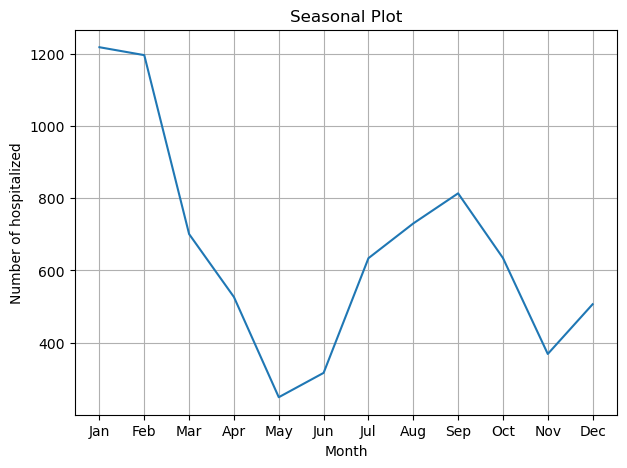

In [21]:
# Seasonal plot 
plt.figure(figsize=(7, 5)) 
sns.lineplot(x=nsick.index.month, y=nsick['hospitalized'], ci=None) 
plt.xlabel('Month') 
plt.ylabel('Number of hospitalized') 
plt.title('Seasonal Plot') 
plt.xticks(range(1, 13), labels=[ 
		'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 
plt.grid(True) 
plt.show() 


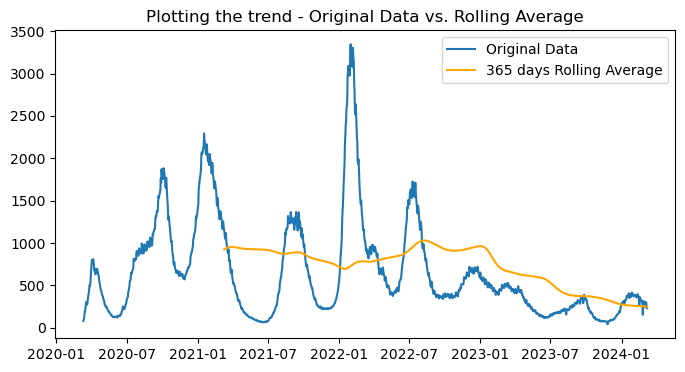

In [22]:
# A trend can be upward, downward, or flat. 
## Identifying trends is vital because they can influence the overall direction of your forecasts.
# For this, we can apply rolling averages to smooth out short-term fluctuations.
# Calculating a 12-month rolling average
nsick['rolling_avg'] = nsick['hospitalized'].rolling(window=365).mean()

plt.figure(figsize=(8, 4))
plt.plot(nsick['hospitalized'], label='Original Data')
plt.plot(nsick['rolling_avg'], label='365 days Rolling Average', color='orange')
plt.title('Plotting the trend - Original Data vs. Rolling Average')
plt.legend()
plt.show()

In [23]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1]  # Return the p-value
    
cols = ['hospitalized']
for column in cols:
    p_value = check_stationarity(nsick[column])
    print(f"Column '{column}': p-value = {p_value}")
    if p_value <= 0.05:
        print(f"  The series '{column}' is likely stationary")
    else:
        print(f"  The series '{column}' is likely non-stationary")
    print()

cols = ['respirated']
for column in cols:
    p_value = check_stationarity(nsick[column])
    print(f"Column '{column}': p-value = {p_value}")
    if p_value <= 0.05:
        print(f"  The series '{column}' is likely stationary")
    else:
        print(f"  The series '{column}' is likely non-stationary")
    print()

Column 'hospitalized': p-value = 0.0105308854520531
  The series 'hospitalized' is likely stationary

Column 'respirated': p-value = 0.010127347052755174
  The series 'respirated' is likely stationary



Autocorrelation measures the linear relationship between a time series and its lagged values. In simpler terms, it assesses how much the current value of a series depends on its past values.

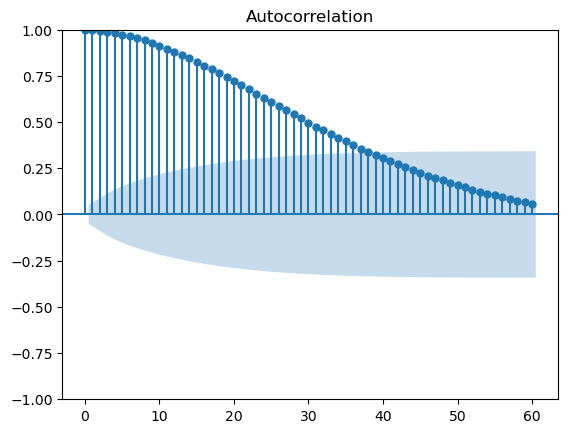

In [25]:
# Autocorrelation 
## The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
plot_acf(sick["hospitalized"],lags=60,title="Autocorrelation")
plt.show()

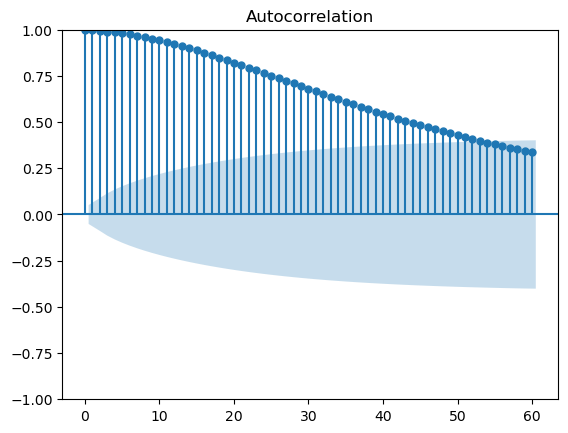

In [26]:
# Autocorrelation
plot_acf(nsick["respirated"],lags=60,title="Autocorrelation")
plt.show()
# after 50 days insignifcant to correlation 

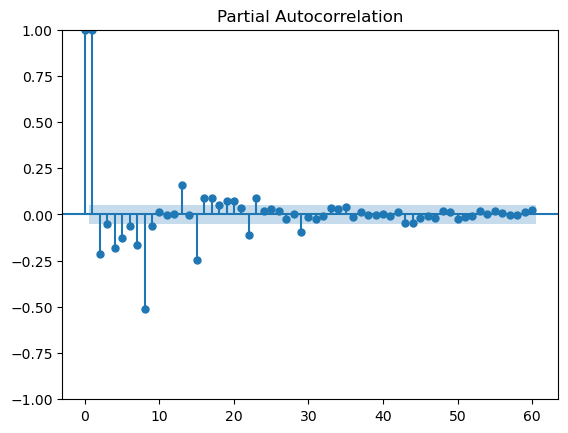

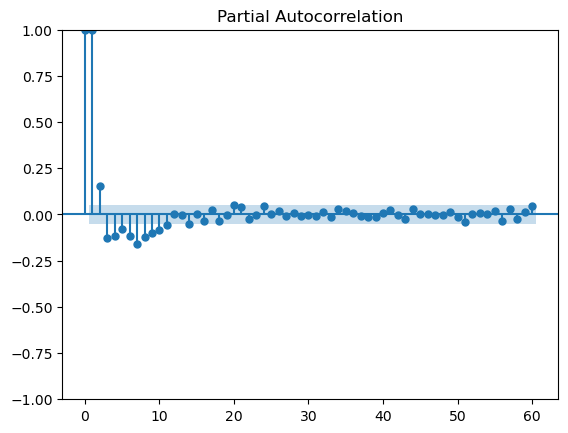

In [27]:
# Partial Autocorrelation
plot_pacf(nsick["hospitalized"],lags=60)
plt.show()
plot_pacf(nsick["respirated"],lags=60)
plt.show()
# האם יש משמעות לכמות מסוימת של ימים קדימה אם אני מנקה את השפעת הקודמים

In [28]:
#Time-Series Data Splitting: How to Avoid Data Leakage in Machine Learning
# Example - a visual representation of how TimeSeriesSplit works. 
# Each fold uses a progressively larger training set and a future time period for testing.
sick_copy = nsick.copy()

# Create lag features to serve as your feature matrix X
sick_copy['lag_1'] = sick_copy['respirated'].shift(1)
sick_copy['lag_2'] = sick_copy['respirated'].shift(2)
sick_copy['lag_3'] = sick_copy['respirated'].shift(3)

# Define X (features) and y (target variable) - Question: Why can't Passengers be a part of X
X = sick_copy[['lag_1', 'lag_2', 'lag_3']]  # Feature matrix: lagged values
y = sick_copy['respirated']  # Target variable


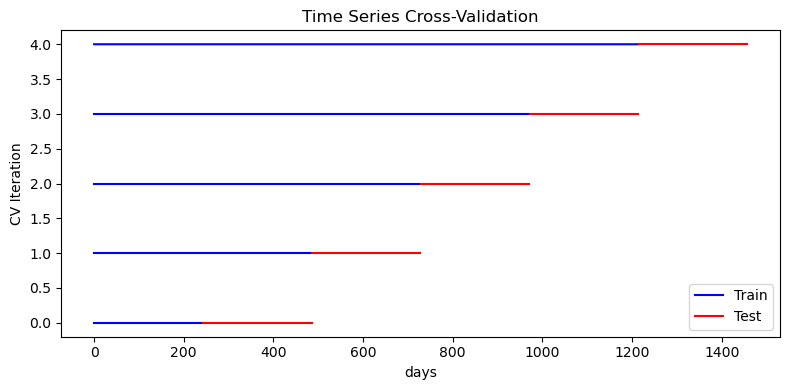

In [29]:
# Apply TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Visualization of Time Series Cross-Validation
fig, ax = plt.subplots(figsize=(8, 4))

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    ax.plot(train_index, [i] * len(train_index), 'b-', label='Train' if i == 0 else '')
    ax.plot(test_index, [i] * len(test_index), 'r-', label='Test' if i == 0 else '')

ax.set_title('Time Series Cross-Validation')
ax.set_xlabel('days')
ax.set_ylabel('CV Iteration')
ax.legend()
plt.tight_layout()
plt.show()

In [30]:
# Chronological split of data into train and test sets
split_index = int(len(X) * 0.7)  # 70% of data for training
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.head() #nan issue 3 first days

,lag_1,lag_2,lag_3
Date,,,
2020-03-11,NaN,NaN,NaN
2020-03-12,7.0,NaN,NaN
2020-03-13,2.0,7.0,NaN
2020-03-14,8.0,2.0,7.0
2020-03-15,12.0,8.0,2.0


In [31]:
# Autoregressive Integrated Moving Average (ARIMA)
n = len(nsick)
ntrain = int(n*0.7)
ntest = n - ntrain
lag = 10

data_train = nsick[:ntrain]
data_test = nsick[ntrain:]
print(data_train.shape, data_test.shape)

(1020, 6) (438, 6)


In [63]:
# arima code by Maya

import itertools

def arima_objective_function(p_values, d_values, q_values, trend_values):

    global n, ntrain, data_train, data_test
    
    params_evaluated = []
    results = []

    # Generate all combinations of p, d, q, and trend
    param_combinations = list(itertools.product(p_values, d_values, q_values, trend_values))

    for p, d, q, trend in param_combinations:
        params = {'p': p, 'd': d, 'q': q, 'trend': trend}
        
        try:
            # Fit ARIMA model with given parameters
            model = ARIMA(data_train, order=(p, d, q), trend=trend).fit()
            y_pred = model.predict(start=ntrain, end=n-1)

            # Calculate root mean squared error
            rmse = sqrt(mean_squared_error(data_test, y_pred))
            params_evaluated.append(params)
            results.append(rmse)
            print(p, d, q, trend, rmse)
        except:
            # If an exception is raised, add a large error as a penalty
            # print(p, d, q, trend)
            # try:
            #     print(f"Error with parameters (p={p}, d={d}, q={q}, trend={trend}): {e}")
            # except:
            #     print("Error", p, d, q, trend)
            params_evaluated.append(params)
            results.append(1e5)
            continue

    return params_evaluated, results, y_pred



In [65]:
# Define your ranges for p, d, q, and trend values
p_values = [0, 1, 2, 3, 8, 9] #partial correlation, choose signifacnt 
d_values = [0, 1, 2]
q_values = [0, 1, 2]
trend_values = ['n', 'c', 't'] # n = no trend, c = constant trend, t = linear trend

# Run the grid search
evaluated_params, rmse_results, y_pred = arima_objective_function(p_values, d_values, q_values, trend_values)

# Find the best parameters based on minimum MSE
best_index = rmse_results.index(min(rmse_results))
best_params = evaluated_params[best_index]
best_rmse = rmse_results[best_index]

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

UnboundLocalError: cannot access local variable 'y_pred' where it is not associated with a value